In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
IMG_FOLDER = '../download_from_drive/data/ProcessedO7'
ANNOTATION_FOLDER = 'annotations/Batch1/ds0/ann/'
ann_paths = [os.path.join(ANNOTATION_FOLDER, fn)[:-5] for fn in os.listdir(ANNOTATION_FOLDER)]

In [4]:
colors = [(255, 0, 255), (255, 0, 0), (0,255,0), (0,255,255), (0,0,255), (130,250,0), (250, 130, 0)]
ann_dict = {'filename':[], 'points':[], 'value':[]}
for ann_name in ann_paths[:]:
#     print(ann_name)
    ann = json.load(open(ann_name+'.json', 'rb+'))
    
    rows = np.array([sorted(np.array(obj['points']['exterior']), key=lambda x: x[0])
                     for obj in ann['objects'] if obj['classTitle']=='row_line'])
    try:
        rows = np.array(sorted(rows, key = lambda x: x[0,1]))
    except:
        print('row', ann_name)
        continue

    columns = np.array([sorted(np.array(obj['points']['exterior']), key=lambda x: x[1])
                               for obj in ann['objects'] if obj['classTitle'].startswith('line')])
    try:
        columns = np.array(sorted(columns, key = lambda x: x[0,0]))
    except:
        print('col', ann_name, columns)
        continue
    cells = [{'point': np.array(obj['points']['exterior'][0]), 'value': obj['tags'][0]['value']}
                     for obj in ann['objects'] if 'line' not in obj['classTitle'] and len(obj['tags'])>0]
    cells = np.array(sorted(cells, key = lambda x: x['point'][1]))
    img_path = os.path.join(IMG_FOLDER, ann_name.split('/')[-1])
#     img = cv2.imread(img_path)
    polygons= []
    for i in range(1, len(rows)):
        for j in range(1, len(columns)):
            weight = (j-1)%4
            y1 = np.average(rows[i-1][:,1], weights=[10.-weight, weight])
            y2 = np.average(rows[i][:,1], weights=[10.-weight, weight])
            weight = (i-1)
            x1 = round(np.average(columns[j-1][:,0], weights=[len(rows)-weight, weight]))
            x2 = round(np.average(columns[j][:,0], weights=[len(rows)-weight, weight]))
            poly = Polygon([(x1, y1), (x1, y2), (x2, y2), (x2, y1)])
            if int(y1) == int(y2):
                print('cos', ann_name, rows)
#             cv2.rectangle(img, (x1, int(y1)), (x2, int(y2)), colors[(i+j)%len(colors)], 2)
            polygons.append(poly)
        
    for poly in polygons:
        contain = 0
        for i, cell in enumerate(cells):
            x, y = cell['point']
            point = Point(x, y)
            if poly.contains(point) or (i==(len(cells)-1) and contain==0):
                polygon = poly
                contain = 1
            else:
                continue
            x1, y1, x2, y2 = np.round(poly.bounds).astype(int)

            delta_y = y2-y1
            delta_x = x2-x1
            y1 += 0.2 * delta_y
            y2 += 0.2 * delta_y
            x1 -= 0.1 * delta_x
            x2 += 0.1 * delta_x
            y1, y2 = round(y1), round(y2)
            x1, x2 = round(x1), round(x2)
#             cv2.rectangle(img, (x1, y1), (x2, y2), colors[i%len(colors)], 5)
            ann_dict['filename'].append(ann_name.split('/')[-1])
            ann_dict['points'].append(tuple([x1,y1,x2,y2]))
            ann_dict['value'].append(cell.get('value') if poly.contains(point) else 'none')
            break
        break
    break
#     plt.figure(figsize=(20, 20))
#     plt.imshow(img); plt.show()
#     break

1


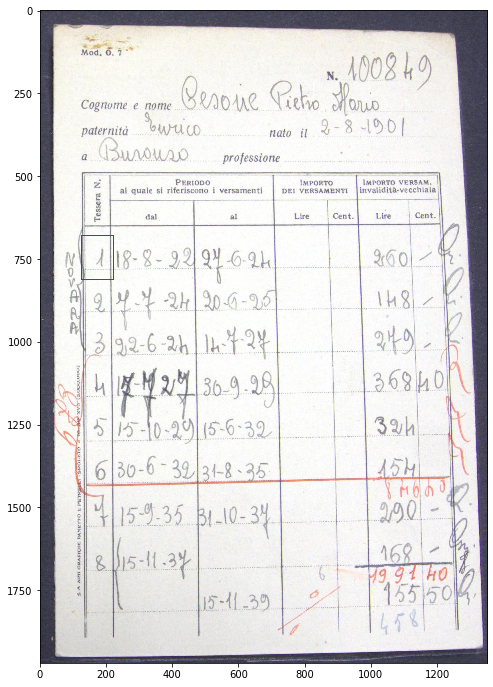

In [11]:
img_path = os.path.join(IMG_FOLDER, ann_dict['filename'][-1].split('/')[-1])
x1, y1, x2, y2 = ann_dict['points'][-1]
value = ann_dict['value'][-1]

plt.figure(figsize=(12,12))
img = plt.imread(img_path)
cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
plt.imshow(img)
print(value)

In [12]:
df_ann = pd.DataFrame(ann_dict)

In [13]:
df_ann.to_csv('./annotations/df_annotations.csv', index=False)
df_ann.to_pickle('./annotations/df_annotations.pkl')

In [14]:
df_ann

,filename,points,value
0,100849_O7_0240.jpg,"(124, 679, 222, 812)",1
1,100849_O7_0240.jpg,"(190, 678, 484, 811)",18-08-22
2,100849_O7_0240.jpg,"(434, 677, 732, 808)",27-06-24
3,100849_O7_0240.jpg,"(125, 811, 223, 939)",2
4,100849_O7_0240.jpg,"(190, 810, 486, 938)",07-07-24
...,...,...,...
8434,91717_O7_0134.jpg,"(652, 1587, 774, 1722)",none
8435,91717_O7_0134.jpg,"(170, 1735, 267, 1866)",none
8436,91717_O7_0134.jpg,"(239, 1730, 482, 1861)",none
8437,91717_O7_0134.jpg,"(442, 1726, 688, 1856)",none


In [7]:
ann_name

'annotations/Batch1/ds0/ann/91717_O7_0134.jpg'

In [8]:
ann_paths[9:10][0]

'annotations/Batch1/ds0/ann/105281_O7_0164.jpg'

In [15]:
np.round(polygons[0].bounds).astype(int)

array([140, 624, 196, 717])

In [36]:
rows

array([[[ 136,  533],
        [1236,  492]],

       [[ 143,  662],
        [1245,  621]],

       [[ 145,  783],
        [1253,  753]],

       [[ 154,  922],
        [1259,  880]],

       [[ 156, 1047],
        [1266, 1013]],

       [[ 162, 1182],
        [1263, 1140]],

       [[ 161, 1312],
        [1276, 1276]],

       [[ 172, 1444],
        [1282, 1399]],

       [[ 169, 1573],
        [1282, 1531]],

       [[ 179, 1709],
        [1290, 1662]],

       [[ 182, 1840],
        [1285, 1792]]])

In [23]:
set([obj['classTitle'] for obj in ann['objects']])

{'line1',
 'line2',
 'line3',
 'line4',
 'numero or tessera n',
 'prima marca or dal',
 'row_line',
 'ultima marca or al'}

In [24]:
rows = np.array([obj['points']['exterior'] for obj in ann['objects'] if obj['classTitle']=='row_line'])
np.array([obj['points']['exterior'] for obj in ann['objects'] if obj['classTitle']=='row_line'])
rows = np.array(sorted(rows, key = lambda x: x[0,1]))

columns = np.array([obj['points']['exterior'] for obj in ann['objects'] if obj['classTitle'].startswith('line')])
columns = np.array(sorted(columns, key = lambda x: x[0,0]))

cells = [{'point': np.array(obj['points']['exterior'][0]), 'value': obj['tags'][0]['value']}
                 for obj in ann['objects'] if 'line' not in obj['classTitle']]

In [25]:
for cell in cells:
    x, y = cell['point']
    disty = y - np.mean(rows[:,:,1], axis=1)
    distx = x - np.mean(columns[:,:,0], axis=1)
    y1 = [np.mean(rows[:,:,1], axis=1)[idx] for idx in np.argsort(disty) if disty[idx]<0][-1]
    y2 = [np.mean(rows[:,:,1], axis=1)[idx] for idx in np.argsort(disty) if disty[idx]>0][0]
    x1 = [np.mean(columns[:,:,0], axis=1)[idx] for idx in np.argsort(distx) if distx[idx]<0][-1]
    x2 = [np.mean(columns[:,:,0], axis=1)[idx] for idx in np.argsort(distx) if distx[idx]>0][0]
    print(x1, y1, x2, y2)

221.0 778.0 136.0 648.5
468.5 778.0 221.0 648.5
718.5 778.0 468.5 648.5
221.0 906.5 136.0 778.0
221.0 1036.0 136.0 906.5
221.0 1155.0 136.0 1036.0
221.0 1291.5 136.0 1155.0
221.0 1423.5 136.0 1291.5
221.0 1547.5 136.0 1423.5
221.0 1681.0 136.0 1547.5
468.5 906.5 221.0 778.0
468.5 1036.0 221.0 906.5
468.5 1155.0 221.0 1036.0
468.5 1291.5 221.0 1155.0
468.5 1423.5 221.0 1291.5
468.5 1547.5 221.0 1423.5
468.5 1681.0 221.0 1547.5
718.5 906.5 468.5 778.0
718.5 1036.0 468.5 906.5
718.5 1155.0 468.5 1036.0
718.5 1291.5 468.5 1155.0
718.5 1423.5 468.5 1291.5
718.5 1547.5 468.5 1423.5
718.5 1805.0 468.5 1681.0


In [8]:
columns

array([[[ 132,  649],
        [ 140, 1885]],

       [[ 214,  649],
        [ 228, 1890]],

       [[ 459,  650],
        [ 478, 1896]],

       [[ 707,  645],
        [ 730, 1885]]])

In [60]:
DATA_FOLDER = '250000_Final'
img_paths = [os.path.join(DATA_FOLDER, number_folder, fn) for number_folder in os.listdir(DATA_FOLDER)
    for fn in os.listdir(os.path.join(DATA_FOLDER, number_folder))]

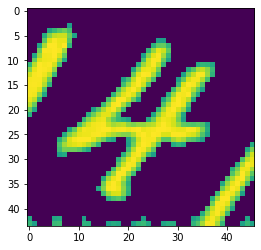

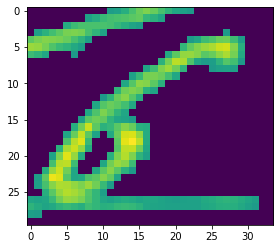

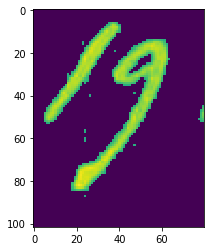

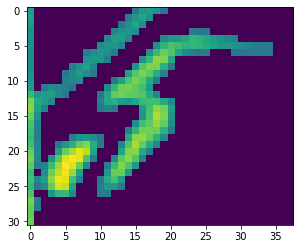

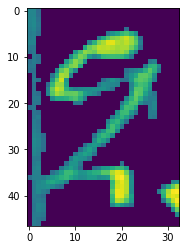

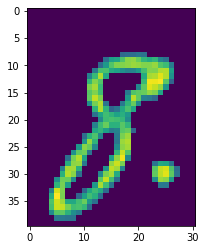

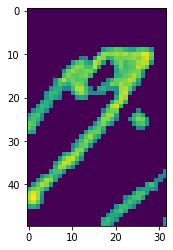

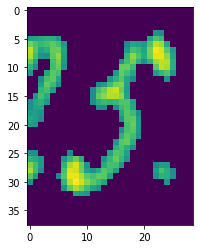

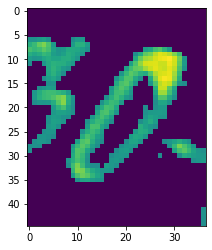

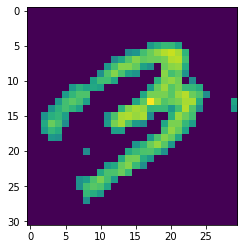

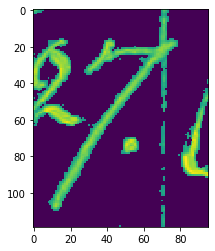

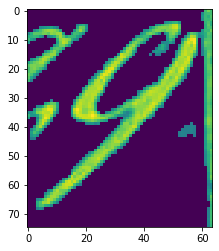

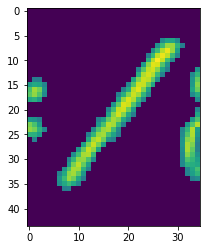

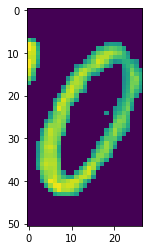

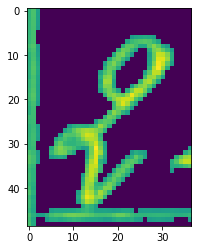

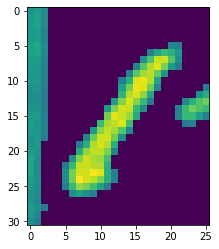

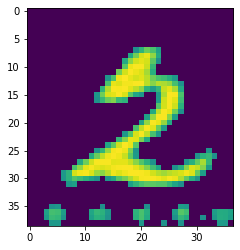

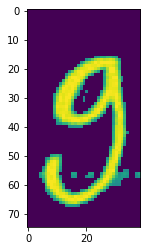

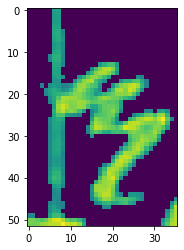

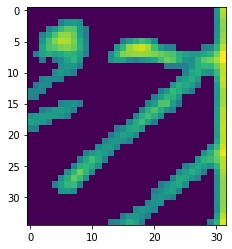

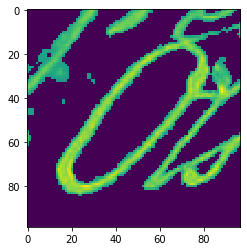

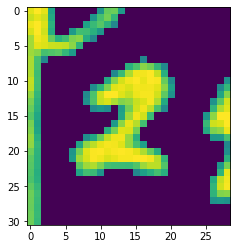

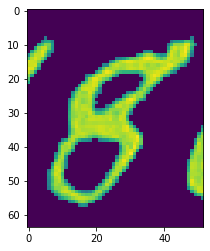

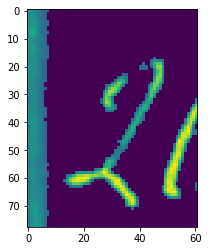

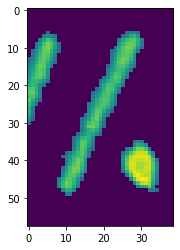

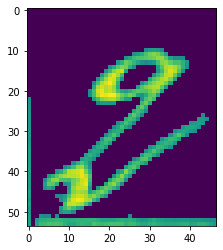

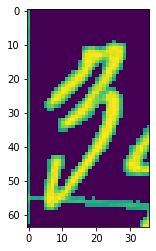

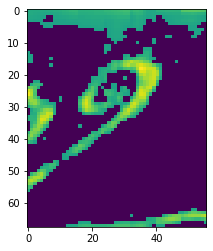

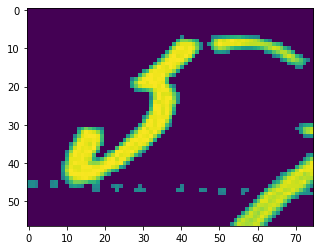

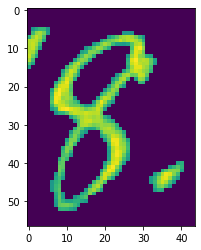

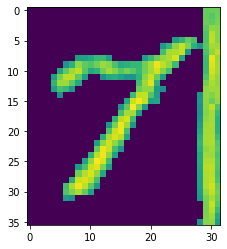

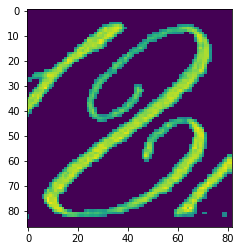

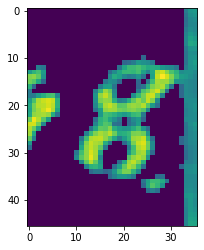

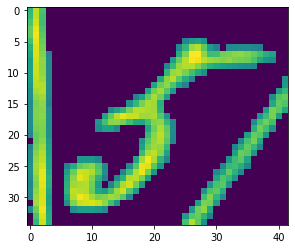

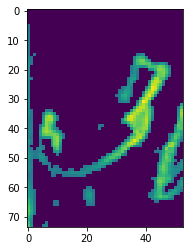

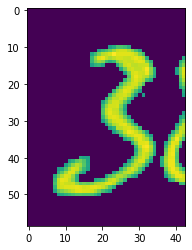

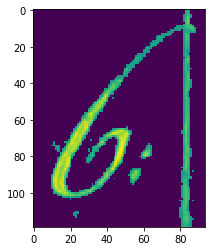

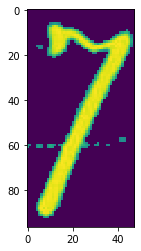

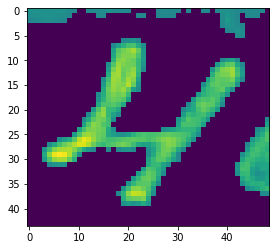

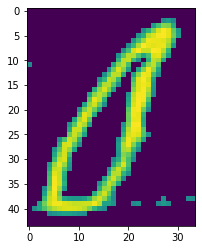

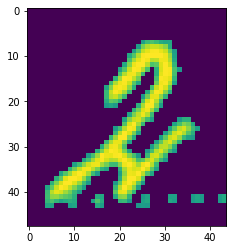

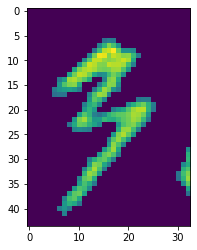

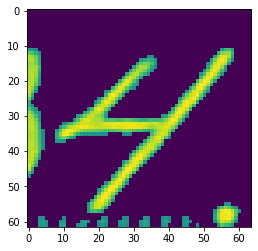

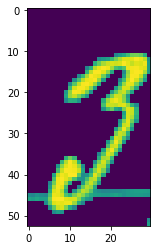

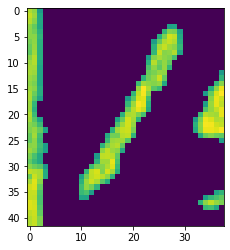

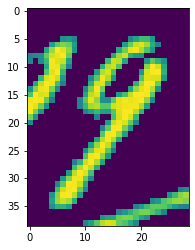

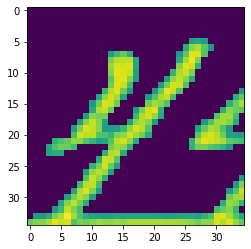

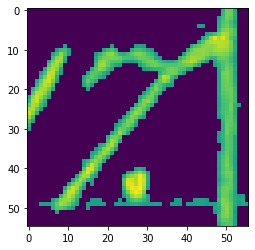

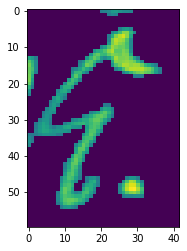

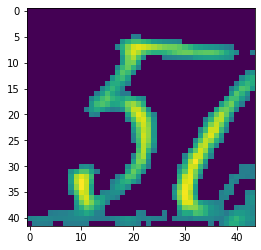

In [64]:
np.random.shuffle(img_paths)
for path in img_paths[:50]:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = 255 - img
    img[img<(np.median(img) + np.std(img)/2)] = 0
    plt.imshow(img); plt.show()

In [52]:
np.median(img), np.std(img)

(42.0, 30.045424648894798)